# Experiments for Complete Graph

## Imports

In [26]:
%load_ext autoreload
%autoreload 2

import os
import sys

from collections import OrderedDict
import logging
import math

from matplotlib import pyplot as plt
import networkx as nx
import numpy as np

import torch
from torchdiffeq import odeint, odeint_adjoint

sys.path.append('../kuramoto_utilities/')
sys.path.append('../../')

# Nodec imports
from neural_net import EluTimeControl, TrainingAlgorithm
from dynamics_driver import ForwardKuramotoDynamics

# Various Utilities
from utilities import evaluate, calculate_critical_coupling_constant, comparison_plot, state_plot
from nnc.helpers.torch_utils.oscillators import order_parameter_cos

logging.getLogger().setLevel(logging.CRITICAL) # set to info to look at loss values etc.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load graph parameters
Basic setup for calculations, graph, number of nodes, etc.

In [27]:
#G = nx.grid_graph([32,32], periodic=False)
dtype = torch.float32
device = 'cpu'
graph_type = 'square_lattice'
adjacency_matrix = torch.load('../../../data/'+graph_type+'_adjacency.pt')
parameters = torch.load('../../../data/parameters.pt')
# driver vector is a column vector with 1 value for driver nodes
# and 0 for non drivers.
driver_vector = torch.ones([adjacency_matrix.shape[0],1])

result_folder = '../../results/' + graph_type + os.path.sep
os.makedirs(result_folder, exist_ok=True)

In [28]:
total_time = 2#parameters['total_time']
natural_frequencies = parameters['natural_frequencies']

critical_coupling_constant = calculate_critical_coupling_constant(adjacency_matrix, natural_frequencies)
coupling_constant = 0.1*critical_coupling_constant
theta_0 = parameters['theta_0']
theta_0[0][:len(theta_0[0])//2]=-np.pi/4+torch.normal(0,torch.tensor((len(theta_0[0])//2)*[0.1]))#0.5*(torch.rand(len(theta_0[0])//2)-0.5)
theta_0[0][len(theta_0[0])//2:]=np.pi/4+torch.normal(0,torch.tensor((len(theta_0[0])//2+1)*[0.1]))#0.5*(torch.rand(len(theta_0[0])//2+1)-0.5)

In [76]:
dtype = torch.float32
graph_type = 'square_lattice_large'
side_size = 32
dtype = torch.float32
device = 'cpu'

result_folder = '../../results/' + graph_type + os.path.sep

G = nx.grid_graph([side_size, side_size],  periodic=False)
G = nx.relabel_nodes(G, lambda x: x[0]*side_size + x[1])

n_nodes = nx.number_of_nodes(G)
adjacency_matrix = np.array(nx.adjacency_matrix(G).todense())
adjacency_matrix = torch.tensor(adjacency_matrix, dtype=dtype, device=device)



driver_vector = torch.ones([adjacency_matrix.shape[0],1])

result_folder = '../../results/' + graph_type + os.path.sep
os.makedirs(result_folder, exist_ok=True)

In [77]:
total_time = 2
torch.manual_seed(1)
# initial angle
theta_0 = torch.empty([1, n_nodes]).normal_(mean=0, std=0.2)
theta_0[0][:len(theta_0[0])//2]=-np.pi/4+torch.normal(0,torch.tensor((len(theta_0[0])//2)*[0.1]))#0.5*(torch.rand(len(theta_0[0])//2)-0.5)
theta_0[0][len(theta_0[0])//2:]=np.pi/4+torch.normal(0,torch.tensor((len(theta_0[0])//2)*[0.1]))#0.5*(torch.rand(len(theta_0[0])//2+1)-0.5)
# omega
natural_frequencies = torch.empty([n_nodes]).normal_(mean=0, std=0.2)
critical_coupling_constant = calculate_critical_coupling_constant(adjacency_matrix, natural_frequencies)
coupling_constant = 0.1*critical_coupling_constant

## Load dynamics parameters
Load natural frequencies and initial states which are common for all graphs and also calculate the coupling constant which is different per graph. We use a coupling constant value that is $10%$ of the critical coupling constant value.

In [78]:
np.std((torch.randn(len(theta_0[0])//2)).numpy())**2

0.8712502015847612

## Initialize DynamicsLoad dynamics 
Here we initialize the Kuramoto dynamics, both forward and backward (adjoint system). The backward system is used for the control baseline of the ajoint gradient, whereas the forward dynamics are used for both control models.

In [79]:
forward_dynamics = ForwardKuramotoDynamics(adjacency_matrix, 
                                           driver_vector, 
                                           coupling_constant, 
                                           natural_frequencies
                                          )

## No Control
Here we run the dynamics without control to determine the evolution of $r(t)$ and the states when no control is applied. Since the control is multiplicative, no control tranlsates to using $u(t) = 1, \forall t$.

In [80]:
no_control = lambda y,t: torch.tensor([[1]]).float()

control_trajectory, state_trajectory =\
evaluate(forward_dynamics, theta_0, no_control, total_time, 100)
no_control = torch.cat(control_trajectory).squeeze().cpu().detach().numpy()
no_control_states = torch.cat(state_trajectory).cpu().detach().numpy()
no_control_r = order_parameter_cos(torch.tensor(no_control_states)).cpu().numpy()
no_control_e = ((no_control)**2).cumsum(-1)
np.save(result_folder + 'no_control_signal', no_control)
np.save(result_folder + 'no_control_states', no_control_states)
np.save(result_folder + 'no_control_syn_param', no_control_r)

## NODEC
We now train NODEC with a shallow neural network. We initialize the parameters in a deterministic manner, and use stochastic gradient descent to train it. The learning rate, number of epochs and neural architecture may change per graph.

In [81]:
neural_net = EluTimeControl([2])
for parameter in neural_net.parameters():
    parameter.data = torch.ones_like(parameter.data)/1000 # deterministic init!
train_algo = TrainingAlgorithm(neural_net, forward_dynamics, different_loss=True)

In [94]:
best_model = train_algo.train(theta_0, total_time, epochs=100, lr=1)

Current loss is: 0.0289904847741127
Current loss is: 0.02783842198550701
Current loss is: 0.027685871347784996
Current loss is: 0.027592472732067108
Current loss is: 0.02751239947974682
Current loss is: 0.027436409145593643
Current loss is: 0.027362149208784103
Current loss is: 0.027288971468806267
Current loss is: 0.027216712012887
Current loss is: 0.027145298197865486
Current loss is: 0.027074754238128662
Current loss is: 0.027005070820450783
Current loss is: 0.026936251670122147
Current loss is: 0.026868313550949097
Current loss is: 0.02680126577615738
Current loss is: 0.026735099032521248
Current loss is: 0.026669828221201897
Current loss is: 0.02660546824336052
Current loss is: 0.026542004197835922
Current loss is: 0.026479460299015045
Current loss is: 0.026417825371026993
Current loss is: 0.026357106864452362
Current loss is: 0.02629731222987175
Current loss is: 0.02623843401670456
Current loss is: 0.026180483400821686
Current loss is: 0.02612343430519104


KeyboardInterrupt: 

### NODEC Evaluation
we evalaute NODEC by using the same methodology we used for ADG control.

In [95]:
control_trajectory, state_trajectory =\
evaluate(forward_dynamics, theta_0, best_model, total_time, 100)
nn_control = torch.cat(control_trajectory).squeeze().cpu().detach().numpy()
nn_states = torch.cat(state_trajectory).cpu().detach().numpy()
nn_e = (nn_control**2).cumsum(-1)
nn_r = order_parameter_cos(torch.tensor(nn_states)).cpu().numpy()
torch.save(best_model.state_dict(), result_folder + 'best_model.pt')
np.save(result_folder + 'nodec_control_signal', nn_control)
np.save(result_folder + 'nodec_states', nn_states)
np.save(result_folder + 'nodec_syn_param', nn_r)

## Comparison and Evaluation
We compare order parameter, energy and state evolution for the control methods.
The plots below show individual states and energy/order parameter comparisons between ADG and NODEC.

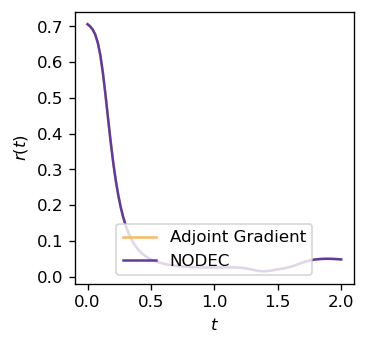

In [96]:
fig = comparison_plot(nn_r, nn_r, np.linspace(0, total_time, nn_r.shape[0]), '$r(t)$')
fig.savefig(result_folder + 'sync_param.pdf')

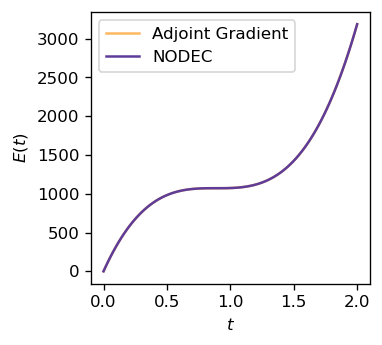

In [97]:
fig = comparison_plot(nn_e, nn_e, np.linspace(0, total_time, nn_e.shape[0]), '$E(t)$', legend_loc='upper left')
fig.savefig(result_folder + 'energy.pdf')

(-1.5, 1.5)

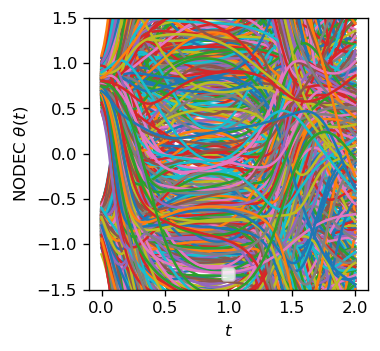

In [98]:
state_plot(nn_states, np.linspace(0, total_time, nn_states.shape[0]), "NODEC $\\theta (t)$")
fig.savefig(result_folder + 'nodec_states.pdf')
plt.ylim(-1.5,1.5)

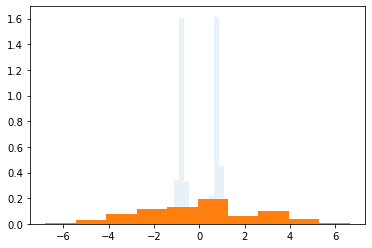

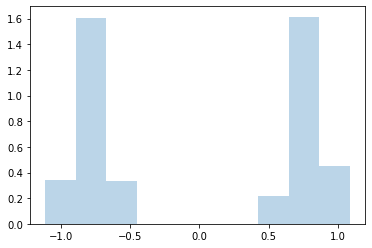

In [99]:
plt.figure()
plt.hist(nn_states[0],density=True,alpha=0.1)
plt.hist(nn_states[-1],density=True)
plt.show()

plt.figure()
plt.hist(theta_0,density=True,alpha=0.3)
plt.show()

In [89]:
print(((((theta_0)**2)**0.5-np.pi/4)**2).sum(),
((((nn_states[-1])**2)**0.5-np.pi/4)**2).sum())

tensor(10.6374) 3879.7402


(-1.5, 1.5)

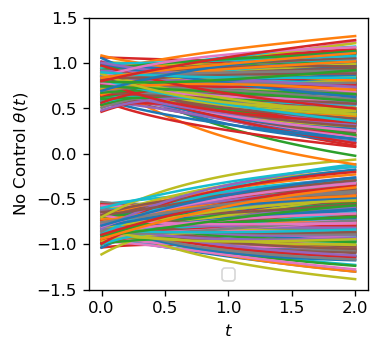

In [90]:
fig = state_plot(no_control_states, np.linspace(0, total_time, no_control_states.shape[0]), "No Control $\\theta (t)$")
fig.savefig(result_folder + 'no_control_states.pdf')
plt.ylim(-1.5,1.5)

In [91]:
print(((((theta_0)**2)**0.5-np.pi/4)**2).sum(),
((((no_control_states[-1])**2)**0.5-np.pi/4)**2).sum())

tensor(10.6374) 47.448753


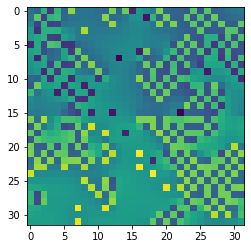

In [93]:
plt.imshow(nn_states[-1].reshape(32,32))

In [907]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
                               
# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 10,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True,
    'text.latex.preamble': [r"\usepackage{bm}", r"\usepackage{mathtools}"]}
    # tell matplotlib about your params

rcParams.update(params)
# set nice figure sizes
fig_width_pt = 510    # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width, 0.5*fig_height]
rcParams.update({'figure.figsize': fig_size})

/home/lucasb/anaconda3/envs/inventory/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [908]:
#np.savetxt("two_states_trajectories.csv",nn_states)
nn_states_two = nn_states

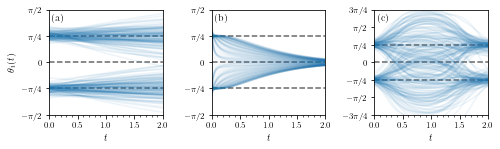

In [960]:
xx = np.linspace(0,total_time,100)
fig, ax = plt.subplots(ncols=3)
ax[0].text(0.02*2,0.89*np.pi-np.pi/2,r"(a)")
ax[1].text(0.02*2,0.89*np.pi-np.pi/2,r"(b)")
ax[2].text(0.02*2,0.89*6*np.pi/4-3*np.pi/4,r"(c)")
ax[0].plot(xx,np.pi/4*np.ones_like(xx),ls="--",color="k",alpha=0.6)
ax[0].plot(xx,-np.pi/4*np.ones_like(xx),ls="--",color="k",alpha=0.6)
ax[0].plot(xx,np.zeros_like(xx),ls="--",color="k",alpha=0.6)
ax[1].plot(xx,np.pi/4*np.ones_like(xx),ls="--",color="k",alpha=0.6)
ax[1].plot(xx,-np.pi/4*np.ones_like(xx),ls="--",color="k",alpha=0.6)
ax[1].plot(xx,np.zeros_like(xx),ls="--",color="k",alpha=0.6)
ax[2].plot(xx,np.pi/4*np.ones_like(xx),ls="--",color="k",alpha=0.6)
ax[2].plot(xx,-np.pi/4*np.ones_like(xx),ls="--",color="k",alpha=0.6)
ax[2].plot(xx,np.zeros_like(xx),ls="--",color="k",alpha=0.6)
ax[0].plot(xx,no_control_states,color="tab:blue",alpha=0.08)
ax[1].plot(xx,nn_states,color="tab:blue",alpha=0.04)
ax[2].plot(xx,nn_states_two,color="tab:blue",alpha=0.08)
ax[0].set_xlim(0,total_time)
ax[1].set_xlim(0,total_time)
ax[2].set_xlim(0,total_time)

ax[0].xaxis.set_minor_locator(MultipleLocator(0.1))
ax[1].xaxis.set_minor_locator(MultipleLocator(0.1))
ax[2].xaxis.set_minor_locator(MultipleLocator(0.1))

ax[0].set_xticks([0,0.5,1.0,1.5,2.0])
ax[1].set_xticks([0,0.5,1.0,1.5,2.0])
ax[2].set_xticks([0,0.5,1.0,1.5,2.0])

ax[0].set_ylim(-np.pi/2,np.pi/2)
ax[0].set_yticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[0].set_yticklabels([r"$-\pi/2$",r"$-\pi/4$",r"$0$",r"$\pi/4$",r"$\pi/2$"])

ax[1].set_ylim(-np.pi/2,np.pi/2)
ax[1].set_yticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[1].set_yticklabels([r"$-\pi/2$",r"$-\pi/4$",r"$0$",r"$\pi/4$",r"$\pi/2$"])

ax[2].set_ylim(-3*np.pi/4,3*np.pi/4)
ax[2].set_yticks([-3*np.pi/4,-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2,3*np.pi/4])
ax[2].set_yticklabels([r"$-3\pi/4$",r"$-\pi/2$",r"$-\pi/4$",r"$0$",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$"])

ax[0].set_xlabel(r"$t$")
ax[1].set_xlabel(r"$t$")
ax[2].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$\theta_i(t)$")
plt.rcParams['savefig.facecolor']='white'
plt.tight_layout()
plt.savefig("kuramoto_two_states.png",dpi=480)
plt.show()